Build project dataset
 - 100 projects, 10 for each of the most popular 10 programming languages
 

In [31]:
import requests
import json
import datetime

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 500)

# Language Selection

The language selection comes from the top 10 technologies from Stackoverflow survey on 2019

In [3]:
languages = [
    "javascript",
    "typescript",
    "java",
    "python",
    "php",
    "c++",
    "c#",
    "c",
    "ruby",
    "go"
]
projects_per_lang = 30

# GitHub Search

To search GitHub, we need an API key, which is founded on the [Developer settings](https://github.com/settings/tokens). 
The following file is private, therefore not versioned.

In [4]:
token=!cat token
headers = {'Authorization': f'Bearer {token[0]}'}

Github GraphQL query to search repositories:

In [5]:
query = '''
    query($qnt: Int!, $query: String!) {
        search(
            query: $query,
            type: REPOSITORY,
            first: $qnt
        ) {
            repositoryCount
            nodes {
                ... on Repository {
                    name: nameWithOwner
                    description
                    url
                    stars: stargazers { totalCount }
                    issues{ totalCount }
                    releases { totalCount }
                    commits: object(expression: "HEAD") {
                        ... on Commit { 
                            last_commit: committedDate
                            history{ totalCount }
                        }
                    }
                    tags: refs(refPrefix: "refs/tags/") { totalCount }
                }
            }
        }
    }
'''

In [6]:
def process_language(lang, data):
    """ Create pandas dataframe from GitHub query response """
    project_lang_data = data['data']['search']['nodes']
    for project_data in project_lang_data:
        project_data['lang'] = lang
        
        # flatten results
        project_data['last_commit'] = project_data['commits']['last_commit']
        project_data['commits'] = project_data['commits']['history']
        for key in project_data.keys():
            if isinstance(project_data[key], dict) and 'totalCount' in project_data[key]:
                project_data[key] = project_data[key]['totalCount']
                
    df = pd.DataFrame.from_dict(data['data']['search']['nodes'])
    return df


In [8]:
print(f'Searching GitHub on {datetime.date.today()}')
github_projects = pd.DataFrame(columns=['name', 'lang', 'stars', 'commits', 'issues', 'tags', 'releases', 'last_commit', 'description', 'url'])

for lang in languages:
    print(f'Searching lang {lang}')
    response = requests.post('https://api.github.com/graphql', headers=headers, json={
        'query': query,
        'variables': { 'query': f'language:{lang} stars:>5000 sort:stars-desc', 'qnt': projects_per_lang }
    })
    if response.ok:
        data = json.loads(response.content)
        project_lang_df = process_language(lang, data)
        github_projects = pd.concat([github_projects, project_lang_df])

Searching GitHub on 2020-07-28
Searching lang javascript
Searching lang typescript
Searching lang java
Searching lang python
Searching lang php
Searching lang c++
Searching lang c#
Searching lang c
Searching lang ruby
Searching lang go


In [9]:
github_projects.last_commit = pd.to_datetime(github_projects.last_commit)
github_projects.stars = pd.to_numeric(github_projects.stars)
github_projects.commits = pd.to_numeric(github_projects.commits)
github_projects.issues = pd.to_numeric(github_projects.issues)
github_projects.releases = pd.to_numeric(github_projects.releases)
github_projects.tags = pd.to_numeric(github_projects.tags)

In [10]:
github_projects.head(10)

,name,lang,stars,commits,issues,tags,releases,last_commit,description,url
0,freeCodeCamp/freeCodeCamp,javascript,312973,25898,14626,0,0,2020-07-28 08:35:56+00:00,freeCodeCamp.org's open source codebase and cu...,https://github.com/freeCodeCamp/freeCodeCamp
1,vuejs/vue,javascript,168854,3104,9092,249,208,2020-07-01 09:11:46+00:00,"🖖 Vue.js is a progressive, incrementally-adopt...",https://github.com/vuejs/vue
2,facebook/react,javascript,153008,13439,9400,131,90,2020-07-28 16:38:13+00:00,"A declarative, efficient, and flexible JavaScr...",https://github.com/facebook/react
3,twbs/bootstrap,javascript,143130,19920,19467,59,59,2020-07-28 13:58:47+00:00,"The most popular HTML, CSS, and JavaScript fra...",https://github.com/twbs/bootstrap
4,airbnb/javascript,javascript,98198,1828,1006,94,0,2020-06-23 05:55:52+00:00,JavaScript Style Guide,https://github.com/airbnb/javascript
5,d3/d3,javascript,92614,4215,2048,263,155,2020-04-20 17:58:56+00:00,"Bring data to life with SVG, Canvas and HTML. ...",https://github.com/d3/d3
6,facebook/react-native,javascript,88975,20577,19819,347,147,2020-07-29 00:28:26+00:00,A framework for building native apps with React.,https://github.com/facebook/react-native
7,facebook/create-react-app,javascript,80613,2569,6024,362,74,2020-07-28 19:38:08+00:00,Set up a modern web app by running one command.,https://github.com/facebook/create-react-app
8,axios/axios,javascript,75563,959,2444,44,23,2020-07-15 16:04:59+00:00,Promise based HTTP client for the browser and ...,https://github.com/axios/axios
9,trekhleb/javascript-algorithms,javascript,75384,812,145,0,0,2020-07-26 11:23:36+00:00,📝 Algorithms and data structures implemented i...,https://github.com/trekhleb/javascript-algorithms


In [11]:
github_projects.shape

(300, 10)

# Project filtering

In [12]:
def select_projects(projects):
    for lang, data in projects.groupby(["lang"]):
        data = data[data.discarded == False].nlargest(n=10, columns="stars")
        projects.loc[projects.name.isin(data.name), 'selected'] = True
    return projects[(projects.selected == True) & (projects.discarded == False)].copy()

In [13]:
def discard_projects(projects, discard, reason):
    projects.loc[projects.name.isin(discard.name), 'discarded'] = reason

In [14]:
def remove_inactive_projects(projects, age):
    """ Remove inactive projects """
    selected_projects = projects[projects.last_commit > age]
    discarded_projects = projects[~projects.name.isin(selected_projects.name)]
    return [selected_projects, discarded_projects, discarded_projects.shape[0]]
    

In [15]:
def remove_small_projects(projects, min_commits):
    """ Remove projects with less commits than min_commits"""
    selected_projects = projects[projects.commits >= min_commits]
    discarded_projects = projects[~projects.name.isin(selected_projects.name)]
    return [selected_projects, discarded_projects, discarded_projects.shape[0]]

In [16]:
def remove_big_projects(projects, max_percent_commits):
    """ Remove projects with more commits than a percentage of total """
    sum_commits = projects.commits.sum()
    projects['perc_commits'] = projects.commits / sum_commits

    selected_projects = projects[projects.perc_commits <= max_percent_commits]
    discarded_projects = projects[~projects.name.isin(selected_projects.name)]
    return [selected_projects, discarded_projects, discarded_projects.shape[0]]

In [17]:
def remove_non_software_projects(projects):
    # go:
    projects.loc[projects.name == 'avelino/awesome-go', 'software'] = False
    projects.loc[projects.name == 'astaxie/build-web-application-with-golang', 'software'] = False

    # java:
    projects.loc[projects.name == 'CyC2018/CS-Notes', 'software'] = False
    projects.loc[projects.name == 'Snailclimb/JavaGuide', 'software'] = False
    projects.loc[projects.name == 'iluwatar/java-design-patterns', 'software'] = False

    # javascript:
    projects.loc[projects.name == 'freeCodeCamp/freeCodeCamp', 'software'] = False
    projects.loc[projects.name == '30-seconds/30-seconds-of-code', 'software'] = False

    # python:
    projects.loc[projects.name == 'public-apis/public-apis', 'software'] = False
    projects.loc[projects.name == 'tensorflow/models', 'software'] = False

    # ruby:
    projects.loc[projects.name == 'freeCodeCamp/devdocs', 'software'] = False
    
    """ Remove non software projects """
    selected_projects = projects[projects.software == True]
    discarded_projects = projects[~projects.name.isin(selected_projects.name)]
    return [selected_projects, discarded_projects, discarded_projects.shape[0]]

## Discard projects

 - Inactive
 - Too small
 - Too big
 - Non software


In [106]:
today = pd.to_datetime('now').tz_localize('UTC').normalize()
delta = pd.to_timedelta(30*6, unit='d')

age = today - delta
min_commits = 2000
max_percent_commits = 0.05

In [188]:
def scan(all_projects, fnc, label, **params):
    converged = False
    cnt_discarded = 0
    while not converged:
        projects = select_projects(all_projects)
        params['projects'] = projects
        [s,d,n] = fnc(**params)
        discard_projects(all_projects, d, label)
        converged = (n == 0)
        cnt_discarded += n
        if n:
            print(f' - discarded {n} - {label}')
    return cnt_discarded

In [197]:
all_projects = github_projects.copy()
all_projects["discarded"] = False
all_projects["software"] = True

round = 1
fully_converged = False
while not fully_converged:
    cnt_discarded = 0
    
    print(f'Round {round}')
    cnt_discarded += scan(all_projects, remove_inactive_projects, 'inactivity', **{ 'age': age })
    cnt_discarded += scan(all_projects, remove_small_projects, 'small', **{ 'min_commits': min_commits })
    cnt_discarded += scan(all_projects, remove_non_software_projects, 'non_software')
    cnt_discarded += scan(all_projects, remove_big_projects, 'big', **{ 'max_percent_commits': max_percent_commits })
    
    fully_converged = (cnt_discarded == 0)
    print(f'Discarded {cnt_discarded} projects\n')
    round += 1 
    

Round 1
 - discarded 2 - inactivity
 - discarded 1 - inactivity
 - discarded 1 - inactivity
 - discarded 23 - small
 - discarded 10 - small
 - discarded 3 - small
 - discarded 9 - non_software
 - discarded 1 - big
 - discarded 2 - big
 - discarded 2 - big
 - discarded 2 - big
Discarded 56 projects

Round 2
 - discarded 5 - small
 - discarded 3 - small
 - discarded 1 - small
Discarded 9 projects

Round 3
Discarded 0 projects



In [172]:
all_projects = github_projects.copy()
all_projects["discarded"] = False
all_projects["software"] = True

round = 1
fully_converged = False
while not fully_converged:
    cnt_discarded = 0
    print(f'Round {round}')
    
    converged = False
    while not converged:
        projects = select_projects(all_projects)
        [s,d,n] = remove_inactive_projects(projects, age)
        discard_projects(all_projects, d, 'inactive')
        converged = (n == 0)
        cnt_discarded += n
        if n:
            print(f' - discarded {n} - inactivity')
        
    
    converged = False
    while not converged:
        projects = select_projects(all_projects)
        [s,d,n] = remove_small_projects(projects, min_commits)
        discard_projects(all_projects, d, 'small')
        converged = (n == 0)
        cnt_discarded += n
        if n:
            print(f' - discarded {n} - small size')
        
    converged = False
    while not converged:
        projects = select_projects(all_projects)
        [s,d,n] = remove_non_software_projects(projects)
        discard_projects(all_projects, d, 'non_software')
        converged = (n == 0)
        cnt_discarded += n
        if n:
            print(f' - discarded {n} - non software')

    converged = False
    while not converged:
        projects = select_projects(all_projects)
        [s,d,n] = remove_big_projects(projects, max_percent_commits)
        discard_projects(all_projects, d, 'big')
        converged = (n == 0)
        cnt_discarded += n
        if n:
            print(f' - discarded {n} - big size')
#         for dp in d.itertuples():
#             print(f' - {pd.to_numeric(dp.perc_commits):3} {dp.name}')
        
    fully_converged = (cnt_discarded == 0)
    print(f'Discarded {cnt_discarded} projects\n')
    round += 1
    
    
projects = select_projects(all_projects).copy()
projects.drop(columns=['discarded', 'software', 'selected'], inplace=True)

Round 1
 - discarded 2 - inactivity
 - discarded 1 - inactivity
 - discarded 1 - inactivity
 - discarded 23 - small size
 - discarded 10 - small size
 - discarded 3 - small size
 - discarded 9 - non software
 - discarded 1 - big size
 - discarded 2 - big size
 - discarded 2 - big size
 - discarded 2 - big size
Discarded 56 projects

Round 2
 - discarded 5 - small size
 - discarded 3 - small size
 - discarded 1 - small size
Discarded 9 projects

Round 3
Discarded 0 projects



In [198]:
all_projects[all_projects.discarded != False].groupby(['discarded']).count().name

discarded
big              7
inactivity       4
non_software     9
small           45
Name: name, dtype: int64

In [199]:
all_projects.dtypes

name                        object
lang                        object
stars                        int64
commits                      int64
issues                       int64
tags                         int64
releases                     int64
last_commit    datetime64[ns, UTC]
description                 object
url                         object
discarded                   object
software                      bool
selected                    object
dtype: object

In [200]:
all_projects.loc[all_projects.discarded != False, ['name', 'discarded', 'commits', 'tags']].sort_values(['discarded','commits'], ascending=[True,False])

,name,discarded,commits,tags
0,torvalds/linux,big,934997,660
5,php/php-src,big,119813,1058
3,apple/swift,big,109625,1658
8,gitlabhq/gitlabhq,big,104118,1215
10,FFmpeg/FFmpeg,big,98586,335
1,kubernetes/kubernetes,big,93077,680
0,tensorflow/tensorflow,big,91663,116
11,julycoding/The-Art-Of-Programming-By-July,inactivity,3633,0
6,bilibili/ijkplayer,inactivity,2584,78
12,SamyPesse/How-to-Make-a-Computer-Operating-System,inactivity,243,12


In [201]:
all_projects[all_projects.discarded != False].groupby(['discarded']).count().name.sum()

65

## Project list for manual inspection

In [202]:
for lang, data in projects.groupby(["lang"]):
    print(f'language: {lang}')
    #for i, project in data.iterrows():
    print(f" - {'stars':6} {'name':25}  {'description'}")
    for project in data.itertuples():
        print(f" - {project.stars:6} {project.name:25}: {project.description}")
    print("\n")


language: c
 - stars  name                       description
 -  47752 netdata/netdata          : Real-time performance monitoring, done right! https://www.netdata.cloud
 -  44379 redis/redis              : Redis is an in-memory database that persists on disk. The data model is key-value, but many different kind of values are supported: Strings, Lists, Sets, Sorted Sets, Hashes, Streams, HyperLogLogs, Bitmaps.
 -  33478 git/git                  : Git Source Code Mirror - This is a publish-only repository and all pull requests are ignored. Please follow Documentation/SubmittingPatches procedure for any of your improvements.
 -  20941 obsproject/obs-studio    : OBS Studio - Free and open source software for live streaming and screen recording
 -  20640 ggreer/the_silver_searcher: A code-searching tool similar to ack, but faster.
 -  18467 tmux/tmux                : tmux source code
 -  17698 curl/curl                : A command line tool and library for transferring data with URL syntax,

# Projects Summary

In [203]:
projects.describe()

,stars,commits,issues,tags,releases
count,100.000000,100.000000,100.000000,100.00000,100.000000
mean,41212.930000,16896.580000,8713.570000,219.61000,95.040000
std,28135.350773,16845.760386,11617.830798,229.92528,125.067571
min,9322.000000,2055.000000,0.000000,0.00000,0.000000
25%,21449.750000,4431.750000,2247.000000,62.75000,13.250000
50%,34469.000000,9610.500000,4546.500000,143.50000,45.000000
75%,49643.500000,25988.000000,12306.500000,279.75000,136.500000
max,168854.000000,77387.000000,94270.000000,1105.00000,619.000000


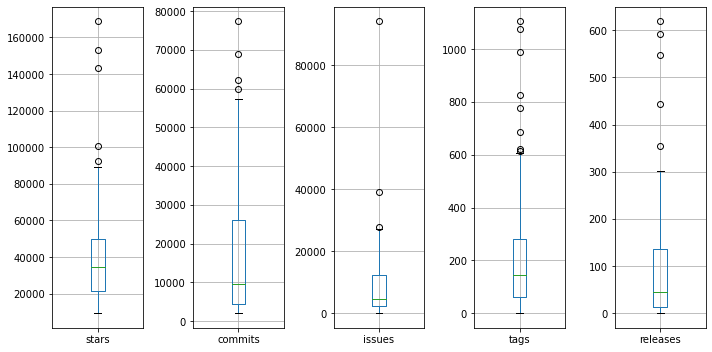

In [204]:
fig, ax = plt.subplots(1, 5, figsize=(10, 5))

projects.boxplot('stars', ax=ax[0])
projects.boxplot('commits', ax=ax[1])
projects.boxplot('issues', ax=ax[2])
projects.boxplot('tags', ax=ax[3])
projects.boxplot('releases', ax=ax[4])

plt.tight_layout()

In [205]:
projects_bylang = projects.groupby('lang')

In [206]:
summary = pd.DataFrame()
summary['stars_mean'] = projects_bylang.stars.mean().round(1)
summary['stars_std'] = projects_bylang.stars.std().round(1)
summary['stars_sum'] = projects_bylang.stars.sum()
summary['commits'] = projects_bylang.commits.mean().round(1)
summary['commits_std'] = projects_bylang.commits.std().round(1)
summary['commits_total'] = projects_bylang.commits.sum()
summary['tags'] = projects_bylang.commits.mean().round(1)
summary['tags_std'] = projects_bylang.commits.std().round(1)
summary['tags_sum'] = projects_bylang.commits.sum()

summary

,stars_mean,stars_std,stars_sum,commits,commits_std,commits_total,tags,tags_std,tags_sum
lang,,,,,,,,,
c,24673.0,12609.1,246730,18073.7,17180.5,180737,18073.7,17180.5,180737
c#,14303.0,3923.8,143030,14901.5,20726.6,149015,14901.5,20726.6,149015
c++,42493.6,15924.7,424936,16062.2,11955.9,160622,16062.2,11955.9,160622
go,40019.1,15233.7,400191,14502.7,14773.0,145027,14502.7,14773.0,145027
java,37716.4,8116.5,377164,13124.0,16775.4,131240,13124.0,16775.4,131240
javascript,98055.2,41370.4,980552,15045.2,11266.2,150452,15045.2,11266.2,150452
php,24005.1,13241.3,240051,12955.4,15231.3,129554,12955.4,15231.3,129554
python,45626.2,10325.2,456262,17693.7,15543.0,176937,17693.7,15543.0,176937
ruby,28301.7,9036.4,283017,25148.4,24875.3,251484,25148.4,24875.3,251484


In [208]:
github_projects.to_pickle('github_projects.zip')
github_projects.to_csv('github_projects.csv')

In [209]:

projects.to_pickle('projects.zip')
projects.to_csv('projects.csv')